In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob

# Zonal mean online error growth

In this notebook, we show how we generate error growth plot, i.e., Figure H1 in "Stable Machine-Learning Parameterization of Subgrid Processes with Real Geography and Full-physics Emulation", Hu et al. 2024, arXiv preprint:2306.08754.

## Set data path

All the simulation output, saved model weights, and preprocessed data used in Hu et al. 2024 "Stable Machine-Learning Parameterization of Subgrid Processes with Real Geography and Full-physics Emulation" are provided in a hu_etal2024_data folder that you can download. Please change the following path to your downloaded hu_etal2024_data folder.

In [3]:
data_path = '/global/homes/z/zeyuanhu/scratch/hu_etal2024_data/'

In [4]:
# Open the dataset
ds_sp = xr.open_mfdataset(data_path+'first_month_hourly/mmf_ref/*.eam.h2.*.nc')
ds_nn = xr.open_mfdataset(data_path+'first_month_hourly/unet_v5/huber_rop/*.eam.h2.*.nc')


In [5]:
ds_grid = xr.open_dataset(data_path+'data_grid/ne4pg2_scrip.nc')
grid_area = ds_grid['grid_area']

def zonal_mean_area_weighted(data, grid_area, lat):
    # Define latitude bins ranging from -90 to 90, each bin spans 10 degrees
    bins = np.arange(-90, 91, 10)  # Create edges for 10 degree bins

    # Get indices for each lat value indicating which bin it belongs to
    bin_indices = np.digitize(lat.values, bins) - 1

    # Initialize a list to store the zonal mean for each latitude bin
    data_zonal_mean = []

    # Iterate through each bin to calculate the weighted average
    for i in range(len(bins)-1):
        # Filter data and grid_area for current bin
        mask = (bin_indices == i)
        data_filtered = data[mask]
        grid_area_filtered = grid_area[mask]

        # Check if there's any data in this bin
        if data_filtered.size > 0:
            # Compute area-weighted average for the current bin
            weighted_mean = np.average(data_filtered, axis=0, weights=grid_area_filtered)
        else:
            # If no data in bin, append NaN or suitable value
            weighted_mean = np.nan

        # Append the result to the list
        data_zonal_mean.append(weighted_mean)

    # Convert list to numpy array
    data_zonal_mean = np.array(data_zonal_mean)

    # The mid points of the bins are used as the representative latitudes
    lats_mid = bins[:-1] + 5

    return data_zonal_mean, lats_mid

ds2 = xr.open_dataset(data_path+'data_grid/E3SM_ML.GNUGPU.F2010-MMF1.ne4pg2_ne4pg2.eam.h0.0001-01.nc')
lat = ds2.lat
lon = ds2.lon
level = ds2.lev.values

def zonal_mean(var):
    var_re = var.reshape(-1,384,var.shape[-1])
    var_re = np.transpose(var_re, (1,0,2))
    var_zonal_mean, lats_sorted = zonal_mean_area_weighted(var_re, grid_area, lat)
    return var_zonal_mean, lats_sorted


## calculate the zonal mean bias (NN - MMF) for moisture and liquid cloud

In [7]:
var = 'Q'
var_sp = ds_sp[var]
var_nn = ds_nn[var]
var_sp_re = np.transpose(var_sp.values, (2,0,1))
var_sp_zonal_mean, lats_sorted = zonal_mean_area_weighted(var_sp_re, grid_area, lat)
var_nn_re = np.transpose(var_nn.values, (2,0,1))
var_nn_zonal_mean, lats_sorted = zonal_mean_area_weighted(var_nn_re, grid_area, lat)

# average in tropics

var_sp_trop = var_sp_zonal_mean[6:12].mean(axis=0)
var_nn_trop = var_nn_zonal_mean[6:12].mean(axis=0)
data_sp = xr.DataArray(var_sp_trop.T, dims=["level", "time"],
                                   coords={"level": level, "time": np.arange(len(ds_sp.time))/24.})

data_nn = xr.DataArray(var_nn_trop.T, dims=["level", "time"],
                                   coords={"level": level, "time": np.arange(len(ds_nn.time))/24.})

bias_q= (data_nn-data_sp)

var = 'CLDLIQ'
var_sp = ds_sp[var]
var_nn = ds_nn[var]
var_sp_re = np.transpose(var_sp.values, (2,0,1))
var_sp_zonal_mean, lats_sorted = zonal_mean_area_weighted(var_sp_re, grid_area, lat)
var_nn_re = np.transpose(var_nn.values, (2,0,1))
var_nn_zonal_mean, lats_sorted = zonal_mean_area_weighted(var_nn_re, grid_area, lat)

# average in tropics

var_sp_trop = var_sp_zonal_mean[6:12].mean(axis=0)
var_nn_trop = var_nn_zonal_mean[6:12].mean(axis=0)
data_sp = xr.DataArray(var_sp_trop.T, dims=["level", "time"],
                                   coords={"level": level, "time": np.arange(len(ds_sp.time))/24.})

data_nn = xr.DataArray(var_nn_trop.T, dims=["level", "time"],
                                   coords={"level": level, "time": np.arange(len(ds_nn.time))/24.})

bias_qc= (data_nn-data_sp)



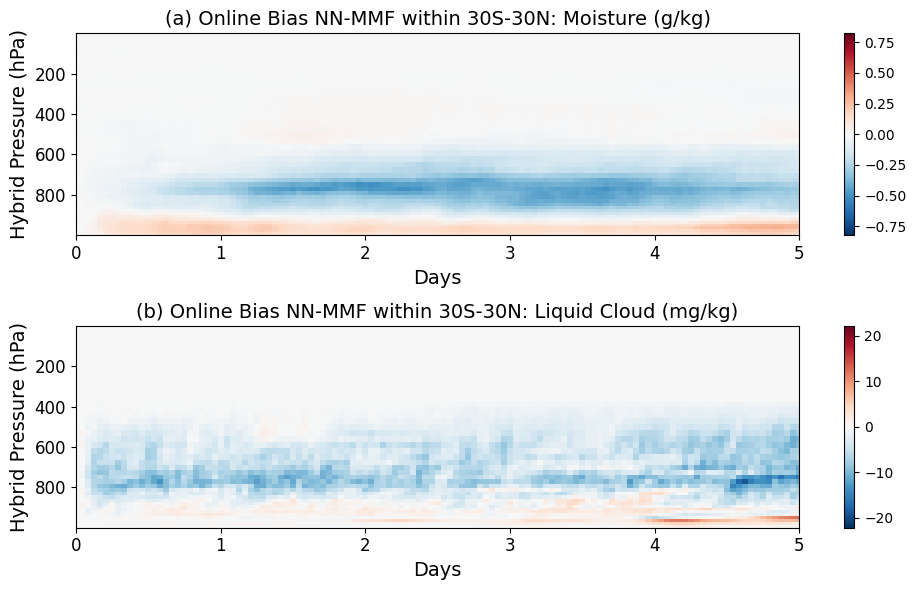

In [8]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Prepare the figure and axes
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

ax = axes[0]
(bias_q*1e3).plot(ax=ax)
ax.invert_yaxis()
ax.set_xlim(0, 5)
ax.set_title('(a) Online Bias NN-MMF within 30S-30N: Moisture (g/kg)',fontsize=14)
ax.set_xlabel('Days',fontsize=14)
ax.set_ylabel('Hybrid Pressure (hPa)',fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

ax = axes[1]
(bias_qc*1e6).plot(ax=ax)
ax.invert_yaxis()
ax.set_xlim(0, 5)
ax.set_title('(b) Online Bias NN-MMF within 30S-30N: Liquid Cloud (mg/kg)',fontsize=14)
ax.set_xlabel('Days',fontsize=14)
ax.set_ylabel('Hybrid Pressure (hPa)',fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
# plt.savefig('/global/homes/z/zeyuanhu/notebooks/james-plots/error-growth.pdf', format='pdf', dpi=300, bbox_inches='tight')

# plt.tight_layout()
plt.show()
